### Importing Libraries

In [1]:
!pip install -U scikit-learn scipy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook',font_scale=1.25)
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML,display
import re
import timeit
import gc

### Import the Dataset

In [2]:
imdb_data = pd.read_csv('IMDB Dataset.csv')
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Some Data cleaning

In [3]:
imdb_data['review'] = imdb_data['review'].apply(lambda x:x.replace('<br /><br />', ''))
imdb_data['review'] = imdb_data['review'].apply(lambda x:x.replace('..', ''))
imdb_data['review'] = imdb_data['review'].apply(lambda x:x.replace('...', ''))
imdb_data['review'] = imdb_data['review'].apply(lambda x:x.replace('....', ''))
imdb_data['review'] = imdb_data['review'].apply(lambda x:x.replace('\'', ''))

In [4]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
imdb_data['review'][1]

'A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great masters of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional dream techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwells murals decorating every surface) are terribly well done.'

In [6]:
imdb_data['review'].duplicated().sum()

419

In [7]:
imdb_data.drop_duplicates(inplace=True)

In [8]:
imdb_data['sentiment'].value_counts()

positive    24884
negative    24697
Name: sentiment, dtype: int64

#### Encoding the label to 1s and 0s

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(imdb_data['sentiment'])
le

LabelEncoder()

In [10]:
imdb_data['label']= le.transform(imdb_data['sentiment'])
imdb_data.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically theres a family where a little boy (...,negative,0
4,"Petter Matteis ""Love in the Time of Money"" is ...",positive,1


In [11]:
imdb_data.drop('sentiment', axis=1, inplace=True)
imdb_data

,review,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy (...,0
4,"Petter Matteis ""Love in the Time of Money"" is ...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,Im going to have to disagree with the previous...,0


<AxesSubplot:xlabel='label', ylabel='Count'>

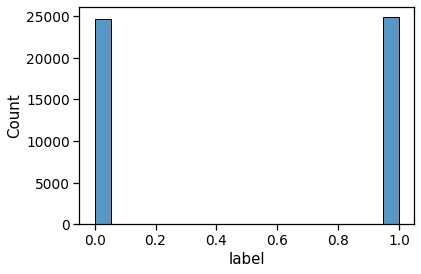

In [14]:
sns.histplot(data=imdb_data, x='label')

In [15]:
imdb_data.isna().sum()

review    0
label     0
dtype: int64

### EDA

#### Negative common words

In [16]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [17]:
from wordcloud import WordCloud,STOPWORDS

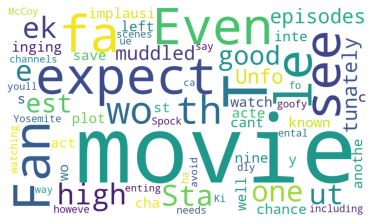

In [18]:
text_list = imdb_data.loc[imdb_data['label']==0,'review'].tolist()
text=""
for sent in text_list:
    sent=re.sub("[<br>]"," ",sent)
    text=re.sub("[^A-Za-z0-9]+"," ",sent)
    text+=sent    

stopwords=set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (5, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


#### Positive common words

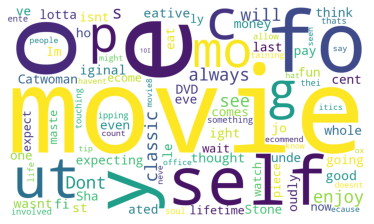

In [19]:
text_list=imdb_data.loc[imdb_data['label']==1,'review'].tolist()
text=""
for sent in text_list:
    sent=re.sub("[<br>]"," ",sent)
    text=re.sub("[^A-Za-z0-9]+"," ",sent)
    text+=sent    

stopwords=set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (5, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#### Model A - SVM

In [20]:
X = imdb_data['review'].values
X[0]

'One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to manyAryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and moreso scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wouldnt d

In [21]:
y= imdb_data['label'].values
y

array([1, 1, 1, ..., 0, 0, 0])

#### Split the data into test and train

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify= y)

In [23]:
# define the SVM model
from sklearn.svm import SVC
svm = Pipeline([
    ('tf-idf',TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB())])



In [24]:
# fit the model
svm.fit(X_train,y_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer(stop_words='english')),
                ('clf', MultinomialNB())])

In [25]:
# make predictions on test data
y_pred_svm = svm.predict(X_test)

In [26]:
print(y_pred_svm)

[0 1 1 ... 0 0 0]


#### Test with sample review

In [27]:
test = svm.predict(['The film was not so bad'])
print(test)

[0]


In [28]:
test = svm.predict(['The film was superb. I can watch it over and over. I love it'])
print(test)

[1]


#### Evaluate the Model

In [29]:
# Compute evaluation metrics
def metrics_check():
    accuracy = accuracy_score(y_test, y_pred_svm)
    precision = precision_score(y_test, y_pred_svm)
    recall =recall_score(y_test, y_pred_svm)
    f1 = f1_score(y_test, y_pred_svm)  

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
metrics_check()   

Accuracy: 0.8614500352929313
Precision: 0.8629860971186782
Recall: 0.860558569419329
F1-score: 0.8617706237424547


### Model B - Long Short-Term Memory (LSTM)

In [30]:
#!pip install keras

In [31]:
#!pip install tensorflow

In [32]:
#!pip install keras

In [33]:
#!pip install tensorflow_hub

#### Importing Libraries

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras import mixed_precision




In [35]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

#### Tokenize the text

In [36]:
# Tokenize text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
X_review = tokenizer.texts_to_sequences(X)
X_review = pad_sequences(X_review, maxlen=100)

#### Split the data into train and test

In [37]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_review, y, test_size=0.2, random_state=42)

####  Define the LSTM Model

In [38]:
from keras.regularizers import l2

# Define LSTM architecture
inputs = Input(shape=(100,))
x = Embedding(input_dim=5000, output_dim=128)(inputs)
x = LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01))(x)
outputs = Dense(1, activation='sigmoid')(x) 
model_lstm = Model(inputs=inputs, outputs=outputs)

In [39]:
# Compile model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 771,713
Trainable params: 771,713
Non-trainable params: 0
_________________________________________________________________


#### Training the Model

In [40]:
# Train model
history= model_lstm.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'model/embedding/embedding_lookup' defined at (most recent call last):
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel\kernelbase.py", line 381, in dispatch_queue
      yield self.process_one()
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tornado\gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tornado\gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-40-4b77fb414cfd>", line 2, in <module>
      history= model_lstm.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\701492\AppData\Roaming\Python\Python39\site-packages\keras\layers\core\embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model/embedding/embedding_lookup'
indices[30,45] = 6417 is not in [0, 5000)
	 [[{{node model/embedding/embedding_lookup}}]] [Op:__inference_train_function_4330]

In [ ]:
print(y_pred_LSTM)

In [ ]:
# Evaluate model on test set
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

In [ ]:
## checking for overfitting
history_df = pd.DataFrame(history.history)
plt.figure(dpi=100, figsize = (7,3))
plt.plot(history_df['loss'],
        label='training_loss')
plt.plot(history_df['val_loss'],
        label='val_loss')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

In [ ]:
def visualpara():
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))

    # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('loss',size=20)
    plt.legend(fontsize=15);
    # plt.show()

    # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('Accuracy',size=20)
    plt.tight_layout()
    plt.legend(fontsize=15);

In [ ]:
visualpara()

#### Model C - Feedforward Neural Network (FFNN)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAvgPool1D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

model_ffnn = Sequential()
model_ffnn.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model_ffnn.add(GlobalAvgPool1D())
model_ffnn.add(Dense(15, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_ffnn.add(BatchNormalization())
model_ffnn.add(Dropout(0.5))
model_ffnn.add(Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_ffnn.add(BatchNormalization())
model_ffnn.add(Dropout(0.5))
model_ffnn.add(Dense(2, activation='sigmoid'))
model_ffnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)




In [42]:
#history = model_ffnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=2)
history = model_ffnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/10
992/992 [==============================] - 19s 18ms/step - loss: 0.6532 - accuracy: 0.7460 - val_loss: 0.3845 - val_accuracy: 0.8484
Epoch 2/10
992/992 [==============================] - 17s 18ms/step - loss: 0.3848 - accuracy: 0.8531 - val_loss: 0.3575 - val_accuracy: 0.8465
Epoch 3/10
992/992 [==============================] - 18s 18ms/step - loss: 0.3384 - accuracy: 0.8716 - val_loss: 0.3492 - val_accuracy: 0.8481
Epoch 4/10
992/992 [==============================] - 18s 18ms/step - loss: 0.3141 - accuracy: 0.8827 - val_loss: 0.3594 - val_accuracy: 0.8462
Epoch 5/10
992/992 [==============================] - 18s 18ms/step - loss: 0.2985 - accuracy: 0.8880 - val_loss: 0.3777 - val_accuracy: 0.8424
Epoch 6/10
992/992 [==============================] - 18s 18ms/step - loss: 0.2840 - accuracy: 0.8975 - val_loss: 0.4103 - val_accuracy: 0.8405
Epoch 7/10
992/992 [==============================] - 18s 18ms/step - loss: 0.2713 - accuracy: 0.9019 - val_loss: 0.3970 - val_accuracy:

In [43]:
# Evaluate model on test set
loss, accuracy = model_ffnn.evaluate(X_test, y_test, batch_size=32)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

310/310 [==============================] - 1s 2ms/step - loss: 0.3581 - accuracy: 0.8435
Test loss: 0.35808613896369934
Test accuracy: 0.8435010313987732


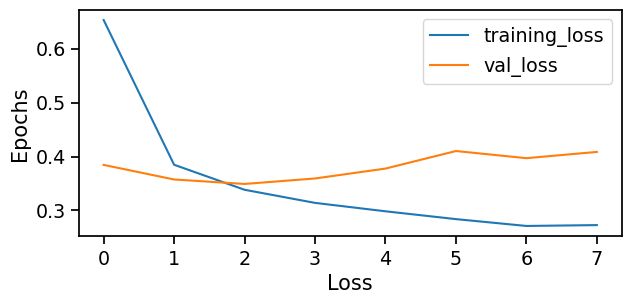

In [44]:
## checking for overfitting
history_df = pd.DataFrame(history.history)
plt.figure(dpi=100, figsize = (7,3))
plt.plot(history_df['loss'],
        label='training_loss')
plt.plot(history_df['val_loss'],
        label='val_loss')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

In [45]:
visualpara()

NameError: name 'visualpara' is not defined

### Model D - SiBERT - Huggingface Transformer based pre-trained model

In [46]:
!pip install tensorflow_hub

Defaulting to user installation because normal site-packages is not writeable


In [47]:
!pip install transformers

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable


In [48]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


####  Import required Libraries

In [49]:
# Import required packages
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
import transformers


In [50]:
# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

### Loading the Model and Tokenizer 

In [51]:
# Load tokenizer and model, create trainer
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

### Get the review text from dataset

In [52]:
imdb_data

,review,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy (...,0
4,"Petter Matteis ""Love in the Time of Money"" is ...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,Im going to have to disagree with the previous...,0


In [57]:
pred_texts = imdb_data['review'].dropna().astype('str').tolist()
pred_texts = pred_texts[:100]
pred_texts


['One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to manyAryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and moreso scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wouldnt 

### Tokenize text for prediction

In [58]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

### Run the predection

In [59]:
# Run predictions
predictions = trainer.predict(pred_dataset)

***** Running Prediction *****
  Num examples = 100
  Batch size = 8


In [60]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

# Create DataFrame with texts, predictions, labels, and scores
df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores)), columns=['text','pred','label','score'])
df.head()

,text,pred,label,score
0,One of the other reviewers has mentioned that ...,1,POSITIVE,0.998806
1,A wonderful little production. The filming tec...,1,POSITIVE,0.998935
2,I thought this was a wonderful way to spend ti...,1,POSITIVE,0.998931
3,Basically theres a family where a little boy (...,0,NEGATIVE,0.999491
4,"Petter Matteis ""Love in the Time of Money"" is ...",1,POSITIVE,0.998890


In [61]:
imdb_data.head()

,review,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy (...,0
4,"Petter Matteis ""Love in the Time of Money"" is ...",1


### CNN-SiEBERT Embedding

In [156]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Input
from tensorflow.keras.models import Model
from transformers import AutoTokenizer, TFAutoModel, AutoModelForSequenceClassification, TFTrainingArguments, TFTrainer


In [93]:
imdb_data = imdb_data.head(500)

In [94]:
X= list(imdb_data["review"])
y= list(imdb_data["label"])

In [95]:
y

[1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


In [112]:
# Load the pre-trained SieBERT tokenizer and model
MODEL = f'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)



In [98]:

tokenized_trian_data = tokenizer(X_train, padding=True, truncation=True)
tokenized_test_data = tokenizer(X_test, padding=True, truncation=True)
##tokenized_data = tokenizer(X_train, return_tensors="pt", padding=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
#tokenized_data = dict(tokenized_data)


In [99]:
tokenized_trian_data

{'input_ids': [[0, 133, 527, 16, 59, 10, 39297, 693, 6, 10886, 6, 54, 2886, 7, 69, 8994, 8, 3772, 6258, 9404, 69, 17292, 6585, 375, 36, 627, 744, 9, 69, 6585, 1441, 8, 14202, 1150, 322, 10886, 28411, 14, 69, 1441, 21, 95, 5, 78, 11, 10, 6755, 9, 13119, 14, 32, 202, 14196, 4, 2615, 69, 39297, 4361, 244, 6136, 5, 3474, 8, 912, 5, 3348, 13119, 116, 370, 269, 33976, 240, 7, 465, 66, 142, 6, 5534, 1308, 1840, 328, 152, 21, 98, 98, 98, 98, 1099, 328, 38, 216, 70, 5, 31801, 6274, 841, 40, 23575, 7, 42, 1569, 8, 492, 24, 7741, 9, 158, 29, 4, 1892, 5, 1079, 9, 201, 40, 192, 41, 9206, 42198, 1471, 9, 231, 8, 888, 206, 42, 1569, 16, 966, 2494, 4, 125, 109, 45, 28, 31952, 4, 20, 3558, 21, 16887, 6, 5, 3501, 28107, 6934, 30876, 36, 417, 2533, 190, 120, 162, 554, 59, 5, 3174, 29296, 1009, 219, 1250, 44431, 8, 5, 527, 21, 2664, 1459, 4, 1801, 2145, 6968, 58, 2449, 328, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [132]:
train_data= tf.data.Dataset.from_tensor_slices((
    dict(tokenized_trian_data), y_train)

)

test_data= tf.data.Dataset.from_tensor_slices((
    dict(tokenized_test_data),y_test)

)

In [151]:
train_data

<TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [160]:
forTrainingArg = TFTrainingArguments(
    output_dir='./scores',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,#for learning rate
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [166]:
with forTrainingArg.strategy.scope():
    model
training = TFTrainer(
    model=model,
    args=forTrainingArg,
    train_dataset=train_data,
    eval_dataset=test_data,
    
)
training.train()

TypeError: train() takes 1 positional argument but 2 were given

In [162]:
training.evaluate(test_data)

TypeError: in user code:

    File "C:\Users\HP PC\anaconda3\lib\site-packages\transformers\trainer_tf.py", line 469, in distributed_prediction_steps  *
        logits = self.args.strategy.run(self.prediction_step, inputs)
    File "C:\Users\HP PC\anaconda3\lib\site-packages\transformers\trainer_tf.py", line 456, in prediction_step  *
        per_example_loss, logits = self.run_model(features, labels, False)
    File "C:\Users\HP PC\anaconda3\lib\site-packages\transformers\trainer_tf.py", line 758, in run_model  *
        outputs = self.model(features, labels=labels, training=training)[:2]
    File "C:\Users\HP PC\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 1194, in _call_impl  *
        return forward_call(*input, **kwargs)

    TypeError: tf__forward() got an unexpected keyword argument 'training'


In [48]:
##test_imdb_data = imdb_data.head(20)
##test_imdb_data

,review,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy (...,0
4,"Petter Matteis ""Love in the Time of Money"" is ...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [78]:
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
from scipy.special import softmax

#Defines a funtion for the SiEBERT scores
def siebert_scores(sample_text):
    # Load and compile our model
    output = model(**tokenized_data) 
    # Lower learning rates are often better for fine-tuning transformers
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores
    result_dict= {
        'Negative': scores[0],
        'Positive': scores[1],
    }
    return result_dict

In [76]:
#siebert_scores('The film is lovely to watch')

###### replaced with next line of code
store=[]
for i, row in test_imdb_data.iterrows():
    try:
        review = row['review']
        #print(review)
        #my_id= row['index']
        siebert_result = siebert_scores(review)
        store[i]= siebert_result
    except RuntimeError:
        print(f'Review text at index too large')

        

In [79]:
test_imdb_data['Polarity Score'] = test_imdb_data['review'].apply(lambda x: siebert_scores(x[:512]))

In [83]:
test_imdb_data

,review,label,Polarity Score
0,One of the other reviewers has mentioned that ...,1,"{'Negative': 0.0011938357, 'Positive': 0.9988061}"
1,A wonderful little production. The filming tec...,1,"{'Negative': 0.0011938357, 'Positive': 0.9988061}"
2,I thought this was a wonderful way to spend ti...,1,"{'Negative': 0.0011938357, 'Positive': 0.9988061}"
3,Basically theres a family where a little boy (...,0,"{'Negative': 0.0011938357, 'Positive': 0.9988061}"
4,"Petter Matteis ""Love in the Time of Money"" is ...",1,"{'Negative': 0.0011938357, 'Positive': 0.9988061}"
5,"Probably my all-time favorite movie, a story o...",1,"{'Negative': 0.0011938357, 'Positive': 0.9988061}"
6,I sure would like to see a resurrection of a u...,1,"{'Negative': 0.0011938357, 'Positive': 0.9988061}"
7,"This show was an amazing, fresh & innovative i...",0,"{'Negative': 0.0011938357, 'Positive': 0.9988061}"
8,Encouraged by the positive comments about this...,0,"{'Negative': 0.0011938357, 'Positive': 0.9988061}"
9,If you like original gut wrenching laughter yo...,1,"{'Negative': 0.0011938357, 'Positive': 0.9988061}"


In [60]:
result_data= pd.DataFrame(store).T
result_data= result_data.merge(test_imdb_data, how='left')



MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [61]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss= 'sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])






AttributeError: 'RobertaForSequenceClassification' object has no attribute 'compile'

In [ ]:
model.fit(tokenized_data, labels)